### PACKAGES, OPTIONS, CONSTANTS

In [1]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

### FUNCTIONS

In [2]:
def etl_hospitalizaciones():
    """
    Generación de df histórico de ingresos, altas y ocupación de hospitales a partir de extracción de CMBD.
    """
    
    # Hospitalizaciones
    filename = 'CMBD_6_20181217-135856.xlsx'
    path = os.path.join('..', 'data', 'external', 'hospitalizaciones', filename)
    raw_df = pd.read_excel(path)
    
    date_cols = ['Fecha de ingreso', 'Fecha de alta']
    keep_cols = ['Sexo', 'Edad', 'Diagnóstico Principal', 'Estancia', 'Coste']
    
    for col in date_cols:
        """
        Dates are codified as integer in DDMMYYYY format, so there's no padding zero if day < 10, i.e:
        28042013 -> 2013-04-28
        7022013 -> 2013-02-07
        """
        raw_df[col + ' new'] = pd.to_datetime(raw_df[col].map(lambda col: str(col).zfill(8)), format='%d%m%Y', errors = 'coerce')
    
    interim_df = raw_df[keep_cols].copy()
    
    for col in date_cols:
        interim_df[col] = raw_df[col + ' new'].copy()
        
     # Ingresos y altas by date
    ingresos_diarios_df = interim_df.groupby(['Fecha de ingreso']).size().reset_index(name = 'Ingresos')
    ingresos_diarios_df.set_index('Fecha de ingreso', inplace = True)
    ingresos_diarios_df.index.names = ['Fecha']
    
    altas_diarias_df = interim_df.groupby(['Fecha de alta']).size().reset_index(name = 'Altas')
    altas_diarias_df.set_index('Fecha de alta', inplace = True)
    altas_diarias_df.index.names = ['Fecha']
    
    # Join by date, cumsum
    hospitalizaciones_df = altas_diarias_df.join(ingresos_diarios_df, how= 'outer')
    hospitalizaciones_df['Ingresos acumulados'] = hospitalizaciones_df['Ingresos'].cumsum()
    hospitalizaciones_df['Altas acumuladas'] = hospitalizaciones_df['Altas'].cumsum()
    hospitalizaciones_df['Ocupacion'] = hospitalizaciones_df['Ingresos acumulados'] - hospitalizaciones_df['Altas acumuladas']
    
    # Export to csv
    hospitalizaciones_df.to_csv(os.path.join('..', 'data', 'processed', 'hospitalizaciones'))
    
    return hospitalizaciones_df

def etl_calidad_aire():
    """
    Generación de df con datos de calidad del aire a partir de histórico en conjunto de ficheros csv.
    """
    
    path = os.path.join('..', 'data', 'external', 'calidad_aire')
    
    # Cargar tabla magnitudes, unidades y técnicas de medida.
    mag_uni_tec_df = pd.read_csv(os.path.join(path,'magnitudes_unidades_tecnicas_medida.csv'))
    
    # Listar ficheros de datos de calidad del aire.
    list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
    list_of_csv_files = [file for file in list_of_files if file.endswith('csv') and file.startswith('datos')]
    
    # Concatenar ficheros de calidad del aire en df.
    raw_df = pd.concat([pd.read_csv(os.path.join(path, file), delimiter = ';') for file in list_of_csv_files])

    #raw_df = pd.read_csv(csv_path, delimiter = ';')
    raw_df = raw_df.merge(mag_uni_tec_df[['MAGNITUD ID', 'MAGNITUD ABREV']], 
                          left_on = 'MAGNITUD', 
                          right_on = 'MAGNITUD ID', 
                          how= 'left') # Pegar descripción de magnitud.
    
    # Trasponer wide to long => añomes to día
    id_cols = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD ABREV', 'PUNTO_MUESTREO', 'ANO', 'MES']
    value_cols = ['D' + str(n).zfill(2) for n in range(1,32,1)]
    
    interim_df = pd.melt(raw_df, id_cols, value_cols)
    interim_df['DIA'] = interim_df['variable'].map(lambda var: var[1:])
    interim_df['FECHA'] = pd.to_datetime(interim_df['ANO'].astype(str) 
                                          + interim_df['MES'].astype(str).str.zfill(2)
                                          + interim_df['DIA'], 
                                         format='%Y%m%d', errors = 'coerce')
    
    key = ['FECHA', 'MAGNITUD ABREV']
    calidad_aire_t_df = interim_df[key + ['value']].groupby(key).mean()
    
    # Trasponer long to wide => fecha, medida 1, medida 2, ..., medida n
    calidad_aire_df = calidad_aire_t_df.pivot_table(index= 'FECHA', 
                                                    columns= 'MAGNITUD ABREV', 
                                                    values= 'value')
    
    return calidad_aire_df

def etl_tabaquismo():
    """
    Generación de df con datos históricos de consumo de tabaco, a partir de agregación de datos de INCLASNS.
    """
    # Cargar csv
    path = os.path.join('..', 'data', 'external', "tabaquismo")
    filename = "inclasns_tabaquismo.csv"
    raw_df = pd.read_csv(os.path.join(path, filename))
    
    # Generar fecha a partir de año
    raw_df['FECHA'] = pd.to_datetime(raw_df['ANO'].astype(str) + '01' + '01', 
                                     format='%Y%m%d', errors = 'coerce')
    
    # Pivotar wide to long => generar [CCAA, value]
    drop_cols = ['ANO']
    id_cols = ['FECHA', 'SEXO']
    value_cols = list(set(raw_df.columns.values).difference(set(drop_cols).union(set(id_cols)))) # Las columnas CCAA son todas las del df menos las id de pivot y las que dropeamos
    interim_df = pd.melt(raw_df, id_cols, value_cols)
    interim_df.rename(columns = {"variable": "CCAA", "value": "PCT_tabaquismo"}, # Renombrar por legibilidad de la siguiente trasposición
                      inplace = True)
    
    # Trasponer long to wide => generar [PCT_tabaquismo_H, PCT_Tabaquismo_M, PCT_Tabaquismo
    
    tabaquismo_df = interim_df.pivot_table(index= ['FECHA','CCAA'], 
                                           columns= 'SEXO', 
                                           values= 'PCT_tabaquismo')
    
    rename_cols = {col: 'PCT_tabaquismo_' + col.lower() for col in tabaquismo_df.columns.values}
    tabaquismo_df.rename(columns = rename_cols, 
                         inplace = True)
    
    tabaquismo_df.reset_index(inplace = True)
    tabaquismo_df.rename_axis(None, axis=1, inplace = True)
    tabaquismo_df.set_index(keys = 'FECHA', inplace = True)
    
    return tabaquismo_df

### ETL PIPELINE

In [3]:
hospitalizaciones_df = etl_hospitalizaciones()
calidad_aire_df = etl_calidad_aire()
tabaquismo_df = etl_tabaquismo()

### EDA

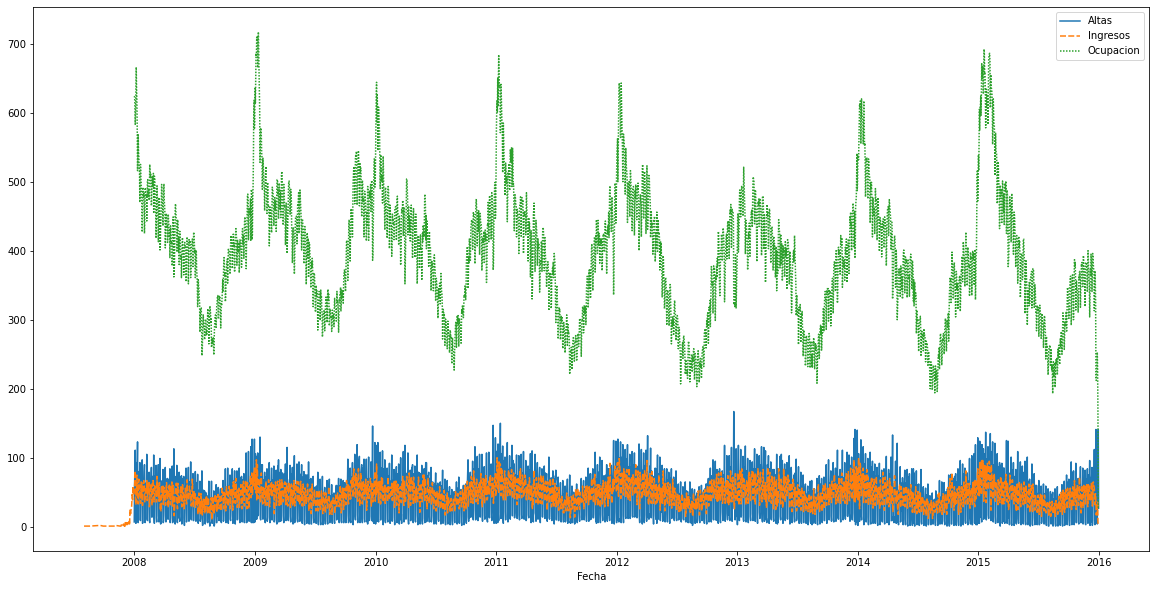

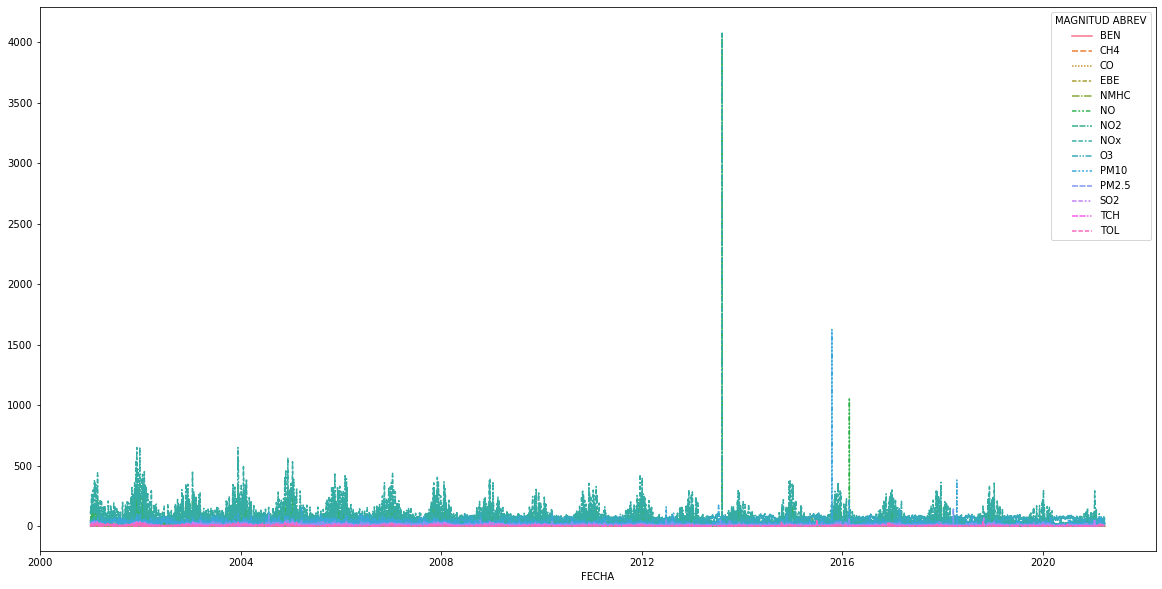

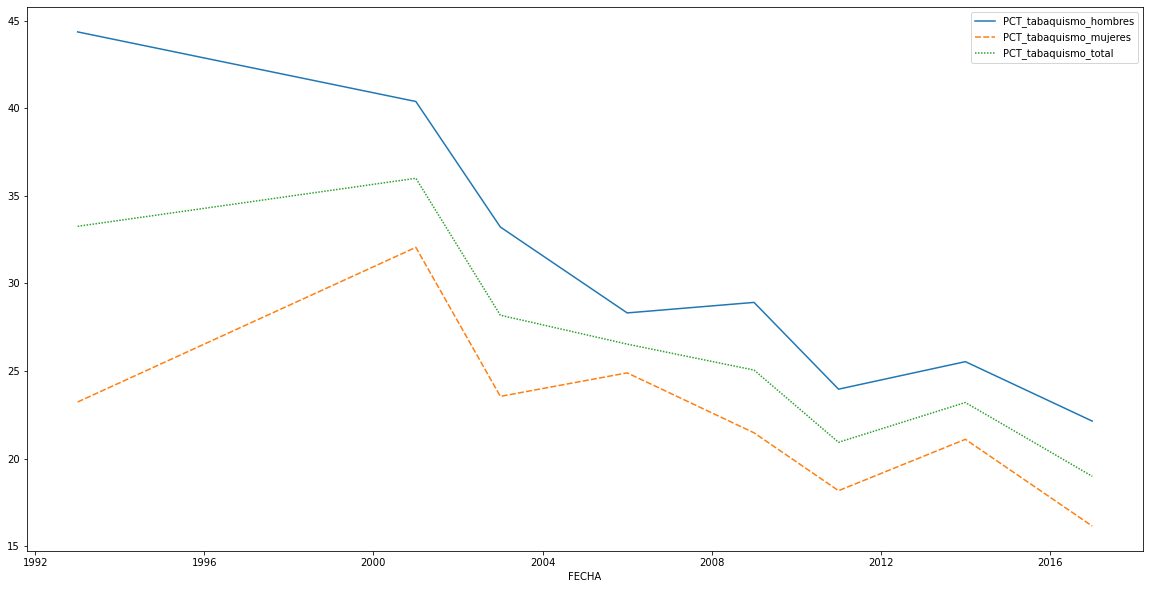

In [9]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

plot_cols = ['Altas','Ingresos','Ocupacion']
sns.lineplot(data=hospitalizaciones_df[plot_cols], ax = ax);

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=calidad_aire_df, ax = ax);

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
filtro = tabaquismo_df['CCAA'] == 'Comunidad de Madrid'
sns.lineplot(data=tabaquismo_df.loc[filtro], ax = ax);

### DATA PREP PIPELINE

In [5]:
merge_all_df = hospitalizaciones_df.join(calidad_aire_df, 
                                         how= 'left')

In [6]:
merge_all_df.head(100)

,Altas,Ingresos,Ingresos acumulados,Altas acumuladas,Ocupacion,BEN,CH4,CO,EBE,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,SO2,TCH,TOL
Fecha,,,,,,,,,,,,,,,,,,,
2007-08-02,NaN,1.0,1.0,NaN,NaN,0.40,1.140000,0.2750,0.85,0.210000,13.416667,41.166667,61.750000,52.666667,36.666667,12.0,6.625,1.346667,4.40
2007-08-20,NaN,1.0,2.0,NaN,NaN,0.25,1.130000,0.1875,0.90,0.170000,6.833333,22.416667,32.833333,62.000000,16.666667,5.0,5.750,1.300000,1.70
2007-09-20,NaN,2.0,4.0,NaN,NaN,0.85,1.190000,0.3250,0.95,0.206667,23.500000,55.250000,91.333333,32.000000,52.666667,25.0,6.250,1.396667,6.00
2007-09-29,NaN,1.0,5.0,NaN,NaN,0.45,1.183333,0.3375,0.90,0.253333,20.666667,51.083333,82.666667,30.833333,38.166667,19.5,6.250,1.430000,3.95
2007-10-22,NaN,1.0,6.0,NaN,NaN,1.00,1.263333,0.5750,1.50,0.363333,77.500000,85.333333,203.666667,15.500000,50.000000,24.0,10.250,1.626667,7.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-19,69.0,61.0,3155.0,2649.0,506.0,0.50,1.173333,0.4000,0.75,0.210000,25.583333,47.750000,87.000000,17.666667,16.500000,9.0,13.125,1.380000,5.60
2008-02-20,57.0,62.0,3217.0,2706.0,511.0,0.75,1.240000,0.5000,1.35,0.256667,52.500000,56.666667,137.333333,12.166667,29.666667,15.5,14.625,1.493333,9.55
2008-02-21,71.0,52.0,3269.0,2777.0,492.0,0.60,1.193333,0.4250,1.05,0.240000,30.583333,49.166667,96.250000,21.166667,24.833333,10.5,15.750,1.430000,9.75
